# **DIPY**

**Conclusion:**
The best signal to noise ratio (SNR) was found by first denoising using mpPCA -> into gibbs correction.
- Further adjustment such as motion correction only worsened the SNR (see SNR_investi.ipynb script). 
- dwMRI was then registered to the t1w structural scans. 

In [1]:
#Homemade Functions
from functions.functions_analysis import *
from functions.Path_combine_function import *
from functions.plot_functions import *
from functions.Preproc_functions import *

#More nifti packages
from nilearn import plotting
import nibabel as nib



# Dipy
import dipy as dp
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.data as dpd

#Preproc
from dipy.align import motion_correction
import dipy.direction.peaks as dpp
from dipy.viz import window, actor
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq

from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma

#DIPY Plot
from dipy.viz import window, actor
from dipy.data import get_sphere

#Regular Packages
import keyboard  # For detecting keypresses
import IPython

import numpy as np
import os
import ants

from pathlib import Path
from time import time
import time  # For simulating work
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy.io

# Preprocessing Simon Data

In [ ]:
path_struc = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/stitched_spinal_cord.nii.gz"
path_wm = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/wm.nii.gz"
path_gm = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/gm.nii.gz"

# Load the nifti files
SIMON_struc, SIMON_affine = load_nifti(path_struc)


##### Denoise ###
# Estimate noise standard deviation
sigma = estimate_sigma(SIMON_struc)

# Apply Non-Local Means (NLM) denoising
denoised_data = nlmeans(SIMON_struc, sigma=sigma, patch_radius=2, block_radius=5)


### Gibbs Correction ####
data_corrected = gibbs_removal(denoised_data, slice_axis=2, num_processes=-1)


#Save the data
outpath = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/gibbs_denoised_stitched_spinal_cord.nii.gz"

data_corrected_nifti = nib.Nifti1Image(data_corrected,   affine = SIMON_affine)
save_nifti(outpath, data_corrected_nifti.get_fdata(),
        data_corrected_nifti.affine)




In [ ]:
## Bias Field Correction 
path = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/gibbs_denoised_stitched_spinal_cord.nii.gz"
data_corrected_nifti = nib.load(path).get_fdata()


In [ ]:
#Mask
SIMON_struc_mask, mask = median_otsu(data_corrected, median_radius=4, numpass=4,
                                     autocrop=False, dilate=None)

#Saving Files
path = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/masked_gibbs_denoised_stitched_spinal_cord.nii.gz"

SIMON_struc_mask_nifti = nib.Nifti1Image(SIMON_struc_mask,   affine = SIMON_affine)
save_nifti(path, SIMON_struc_mask_nifti.get_fdata(),
    SIMON_struc_mask_nifti.affine)

np.save("C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/mask.npy", mask)

In [ ]:
# MASK THE 200x200 DATA
images_paths = ["Simon FODs/hsc2_structural_data_and_gmwm_masks/resized_masked_gibbs_denoised_stitched_spinal_cord_200_200.npy"]
images_data = np.load(images_paths[0]).squeeze()


maskeddata, mask =  median_otsu(images_data, median_radius=4, numpass=4,
                                     autocrop=False, dilate=None, finalize_mask= True)
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/mask_t2_200_200.npy", mask)

In [47]:
#Crop Mask
outpath = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/gibbs_denoised_stitched_spinal_cord.nii.gz"
data_corrected, SIMON_affine = load_nifti(outpath)

z_index = np.arange(200,250,1)
data_corrected_subset = data_corrected[:,:,z_index]

SIMON_struc_mask_crop, mask_crop = median_otsu(data_corrected_subset, median_radius=4, numpass=4,
                                     autocrop=False, dilate=None)

In [101]:
# Find the indices where mask_crop is True
true_indices = np.argwhere(mask_crop)

# Find the smallest and largest index values
min_index = true_indices.min(axis=0)
max_index = true_indices.max(axis=0)

min_index, max_index = min_index-15, max_index+15

min_index, max_index

(array([ 41,  61, -15], dtype=int64), array([330, 281,  64], dtype=int64))

In [117]:
def cropping_sigurd(data):
    shape = data.shape
    # Find the indices where mask_crop is True
    true_indices = np.argwhere(data > 0)

    # Find the smallest and largest index values
    min_index = true_indices.min(axis=0)
    max_index = true_indices.max(axis=0)

    min_index, max_index = min_index-15, max_index+15
    min_index = np.maximum(min_index, 0)

    max_index[0] = np.minimum(max_index[0], shape[0]) 
    max_index[1] = np.minimum(max_index[1], shape[1]) 
    max_index[2] = np.minimum(max_index[2], shape[2]) 


    return(min_index, max_index)

cropping_sigurd(SIMON_struc_mask_crop)

(array([41, 61,  0], dtype=int64), array([330, 281,  50], dtype=int64))

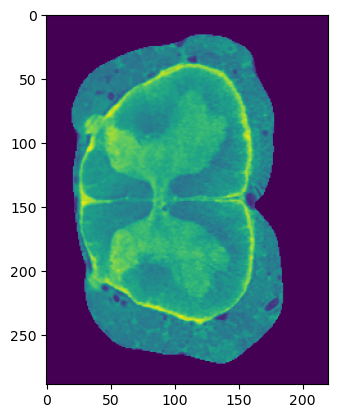

In [93]:
plt.imshow(SIMON_struc_mask_crop[min_index[0]:max_index[0], min_index[1]:max_index[1], 20])

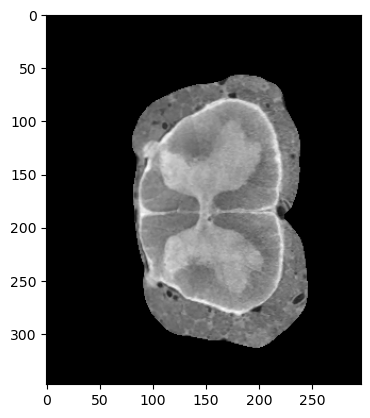

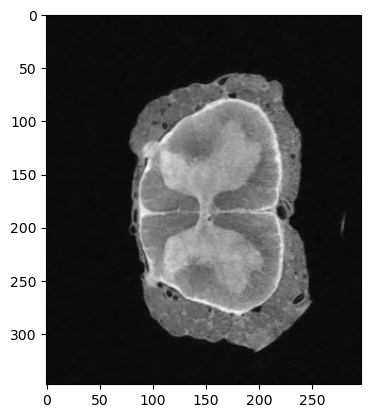

In [83]:
z = 20
plt.imshow(SIMON_struc_mask_crop[:,:,z], cmap='gray')
plt.show()
plt.imshow(data_corrected_subset[:,:,z], cmap='gray')

# Preprocessing Structural

In [2]:
#Structural Files Solo
t2_paths = PathFinder("RARE_2D_Ax.nii")


for path in t2_paths:
    file_path_parent = Path(path).parent
    outpath = os.path.join(file_path_parent, "RARE_2D_Ax_preproc.nii.gz")

    print(f"Starting processing for {path}")

    #check if the file exists
    if os.path.exists(outpath):
        print(f"File already exists: {outpath}")
        continue  # Skip processing if the file already exists

    #Load the nifti files
    RARE_file, RARE_affine = load_nifti(path)
    RARE_file = RARE_file.astype(np.float32)  # Convert to float32 to reduce memory usage

    #Mask
    print("Starting masking...")
    RARE_combined_masked, mask = median_otsu(RARE_file, median_radius=2, numpass=2,
                                        autocrop=False, dilate=None)
    np.save(os.path.join(file_path_parent,"RARE_mask.npy"), mask)
    
    ##### Denoise ###
    print("Starting denoising...")
    # Estimate noise standard deviation
    sigma = estimate_sigma(RARE_file)

    # Apply Non-Local Means (NLM) denoising
    denoised_data = nlmeans(RARE_file, sigma = sigma, patch_radius=2, block_radius=5, mask = mask)

    ### Gibbs Correction ####
    print("Starting Gibbs correction...")
    data_corrected = gibbs_removal(denoised_data, slice_axis=2, num_processes=-1)


    #Save the data
    print("Saving data...")
    RARE_data_nifti = nib.Nifti1Image(data_corrected,   affine = RARE_affine)

    save_nifti(outpath, RARE_data_nifti.get_fdata(),
        RARE_data_nifti.affine)



['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\89-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\92-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\95-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\98-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\101-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\104-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\107-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\110-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\113-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\116-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\119-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\122-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\125-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\128-nii\\RARE_2D_Ax.nii', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\131-nii\\RARE_2D_Ax.nii'

**Intensity Correction of each slab individually**

In [8]:
def evaluate_bias_field_correction(original_image = None, corrected_image = None, bias_field=None, xi = 180 , yi = 180, zi = 40):
    """
    Evaluate the bias field correction by comparing the original and corrected images.
    This function calculates the mean squared error (MSE) and displays both images.
    """
    original_data = original_image.numpy()
    corrected_data = corrected_image.numpy()

    # Calculate the mean squared error (MSE) between the original and corrected images
    mse = np.mean((original_data - corrected_data) ** 2)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    # Display the original and corrected images in sagittal and axial views

    ###### Display Xi ######
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[:, xi, :], cmap='gray')
    plt.title("Original (Coronal)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(corrected_image[:, xi, :], cmap='gray')
    plt.title("Corrected (Coronal)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(bias_field[:, xi, :], cmap='gray')
    plt.title("Bias Field (Coronal View)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    ###### Display zi ######
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[:, :, zi], cmap='gray')
    plt.title("Original (axial)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(corrected_image[:, :, zi], cmap='gray')
    plt.title("Corrected (axial)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(bias_field[:, :, zi], cmap='gray')
    plt.title("Bias Field (Axial View)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    ###### Display yi ######
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[yi, :], cmap='gray')
    plt.title("Original (Sagittal View)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(corrected_image[yi, :], cmap='gray')
    plt.title("Corrected (Sagittal View)")
    plt.axis("off")


    plt.subplot(1,3,3)
    plt.imshow(bias_field[yi,:, :], cmap='gray')
    plt.title("Original (Sagittal View)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()



    #### Compute mean intensity along z (slice axis) ####
    original_data = original_image.numpy()
    corrected_data = corrected_image.numpy()

    # Mean intensity along axes
    # Only calculate mean intensity on non-zero voxels for each slice
    mean_intensity_before = [
        original_data[:, :, z][original_data[:, :, z] > 0].mean() if np.any(original_data[:, :, z] > 0) else 0
        for z in range(original_data.shape[2])
    ]
    mean_intensity_after = [
        corrected_data[:, :, z][corrected_data[:, :, z] > 0].mean() if np.any(corrected_data[:, :, z] > 0) else 0
        for z in range(corrected_data.shape[2])
    ]
    mean_intensity_before_x = [
        original_data[x, :, :][original_data[x, :, :] > 0].mean() if np.any(original_data[x, :, :] > 0) else 0
        for x in range(original_data.shape[0])
    ]
    mean_intensity_after_x = [
        corrected_data[x, :, :][corrected_data[x, :, :] > 0].mean() if np.any(corrected_data[x, :, :] > 0) else 0
        for x in range(corrected_data.shape[0])
    ]
    mean_intensity_before_y = [
        original_data[:, y, :][original_data[:, y, :] > 0].mean() if np.any(original_data[:, y, :] > 0) else 0
        for y in range(original_data.shape[1])
    ]
    mean_intensity_after_y = [
        corrected_data[:, y, :][corrected_data[:, y, :] > 0].mean() if np.any(corrected_data[:, y, :] > 0) else 0
        for y in range(corrected_data.shape[1])
    ]

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(mean_intensity_before, label='Before', linestyle='--')
    plt.plot(mean_intensity_after, label='After', linestyle='-')
    plt.xlabel('Slice (z-axis)')
    plt.ylabel('Mean Intensity')
    plt.title('Mean Intensity (z-axis)')
    plt.legend()
    plt.grid()

    # Add vertical lines every 70th slice
    for x in range(0, len(mean_intensity_before), 70):
        plt.axvline(x=x, color='r', linestyle=':', alpha=0.5)

   

    plt.subplot(1, 3, 2)
    plt.plot(mean_intensity_before_x, label='Before', linestyle='--')
    plt.plot(mean_intensity_after_x, label='After', linestyle='-')
    plt.xlabel('Slice (x-axis)')
    plt.ylabel('Mean Intensity')
    plt.title('Mean Intensity (x-axis)')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(mean_intensity_before_y, label='Before', linestyle='--')
    plt.plot(mean_intensity_after_y, label='After', linestyle='-')
    plt.xlabel('Slice (y-axis)')
    plt.ylabel('Mean Intensity')
    plt.title('Mean Intensity (y-axis)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # Coefficient of variation (CV) across slices

    cv_before = np.std(mean_intensity_before) / np.mean(mean_intensity_before)
    cv_after = np.std(mean_intensity_after) / np.mean(mean_intensity_after)
    print(f"CV before: {cv_before:.4f}, CV after: {cv_after:.4f}")


    # Histogram of intensities before and after correction
    # Flatten and remove zeros
    original_flat = original_data[original_data > 0].flatten()
    corrected_flat = corrected_data[corrected_data > 0].flatten()


    plt.hist(original_flat, bins=100, alpha=0.5, label='Before')
    plt.hist(corrected_flat, bins=100, alpha=0.5, label='After')
    plt.legend()
    plt.title("Histogram of Intensities")
    plt.show()
    
    return mse

In [ ]:
t2_paths = PathFinder("RARE_2D_Ax.nii")
RARE_file3 = ants.image_read(t2_paths[10])


bias_field3 = ants.n4_bias_field_correction(RARE_file3,
                                                shrink_factor=1,  # Adjust shrink factor for speed vs accuracy
                                                mask=None,  # Use the mask if available, or set to  
                                                convergence= {'iters': [50, 50,50, 30], 'tol': 1e-6},                                              
                                                spline_param= [2,2,2],  # Adjust spline parameter for bias field smoothness
                                                return_bias_field=True,  # Set to True if you want to return the bias fieldias field
                                                verbose=False)  # Set to True for detailed output
RARE_corrected3 = RARE_file3 / bias_field3


#file_path_parent = Path(t2_paths[4]).parent
#outpath = os.path.join(file_path_parent, "RARE_2D_Ax_preproc_BFC.nii.gz")
#ants.image_write(RARE_corrected2, outpath) 



# Evaluate bias field correction
evaluate_bias_field_correction(original_image = RARE_file3, corrected_image = RARE_corrected3, bias_field = bias_field3, xi = 110, yi= 200 , zi =40)

Mean Squared Error (MSE): 0.0113


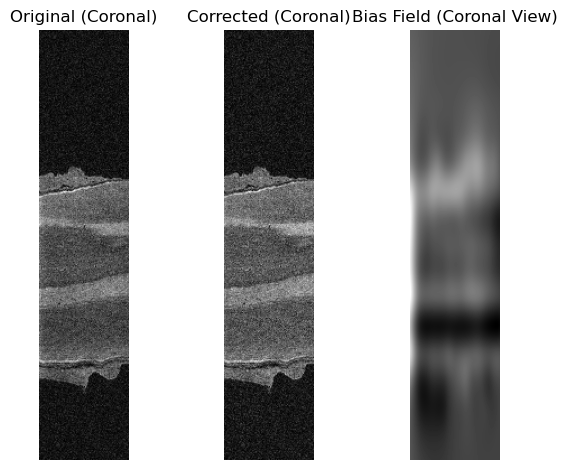

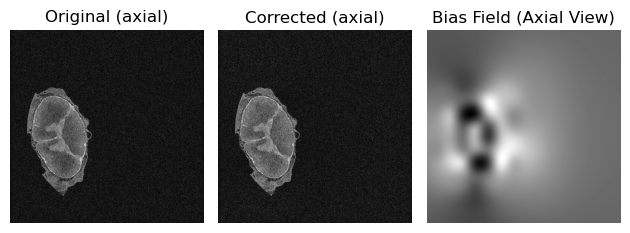

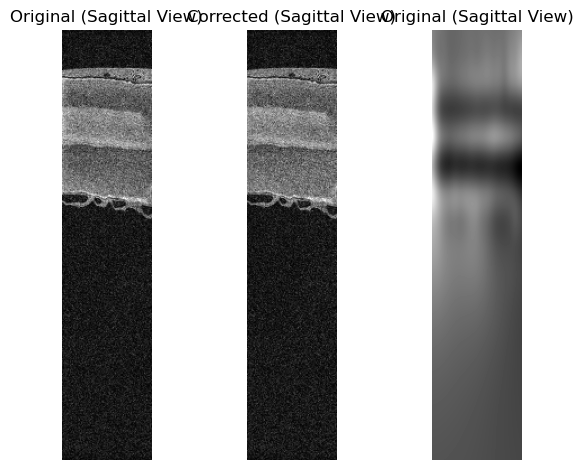

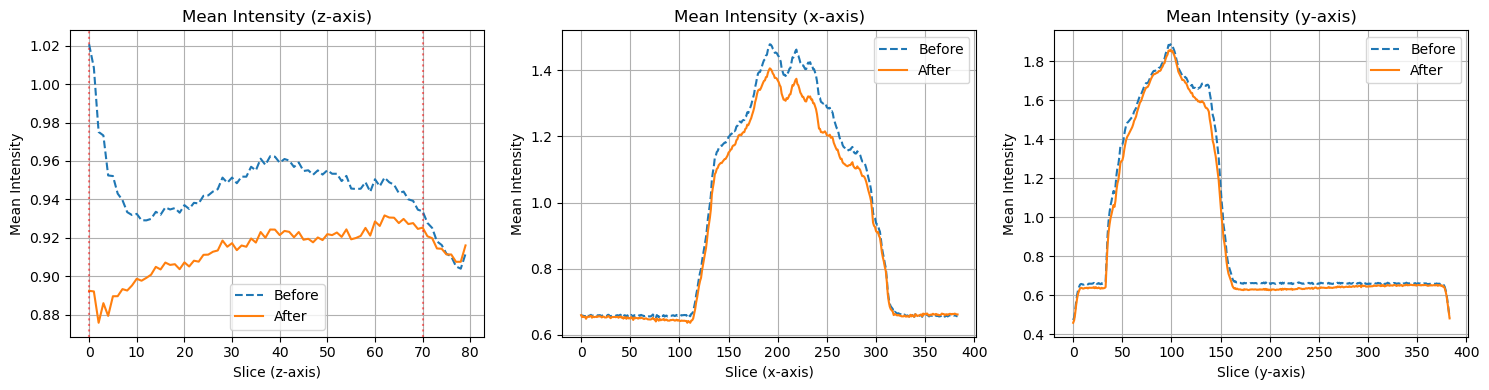

CV before: 0.0192, CV after: 0.0136


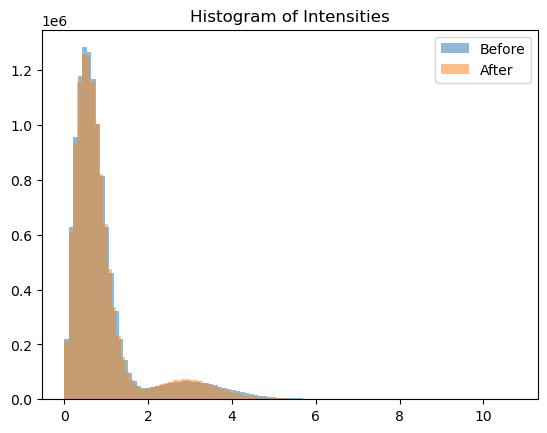

0.011264764

In [7]:

# Evaluate bias field correction
evaluate_bias_field_correction(original_image = RARE_file3, corrected_image = RARE_corrected3, bias_field = bias_field3, xi = 110, yi= 200 , zi =40)

['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\89-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\92-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\95-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\98-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\101-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\104-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\107-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\110-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\113-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\116-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\119-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\122-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\125-nii\\RARE_2D_Ax_prepro

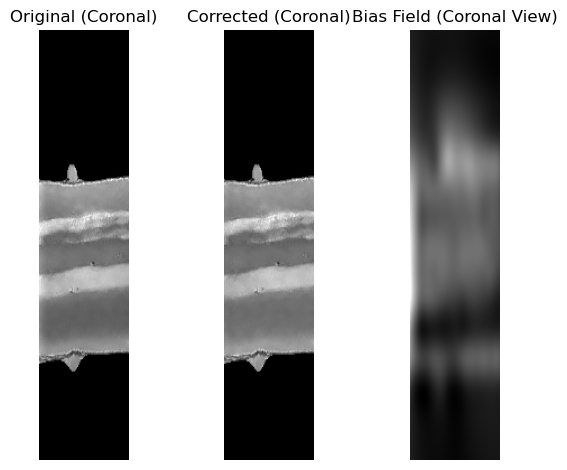

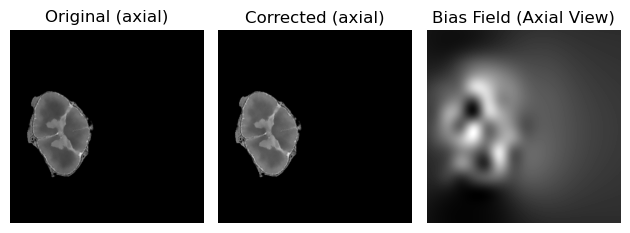

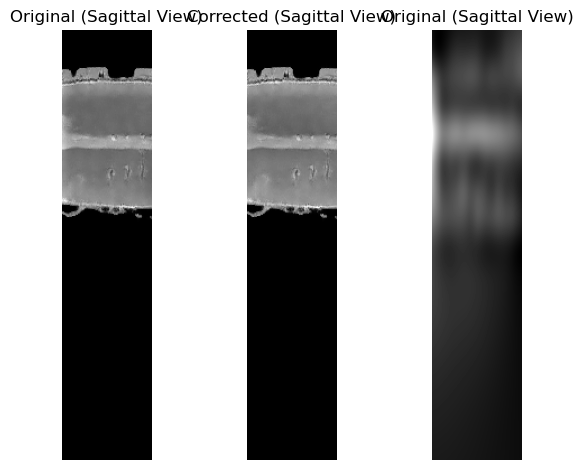

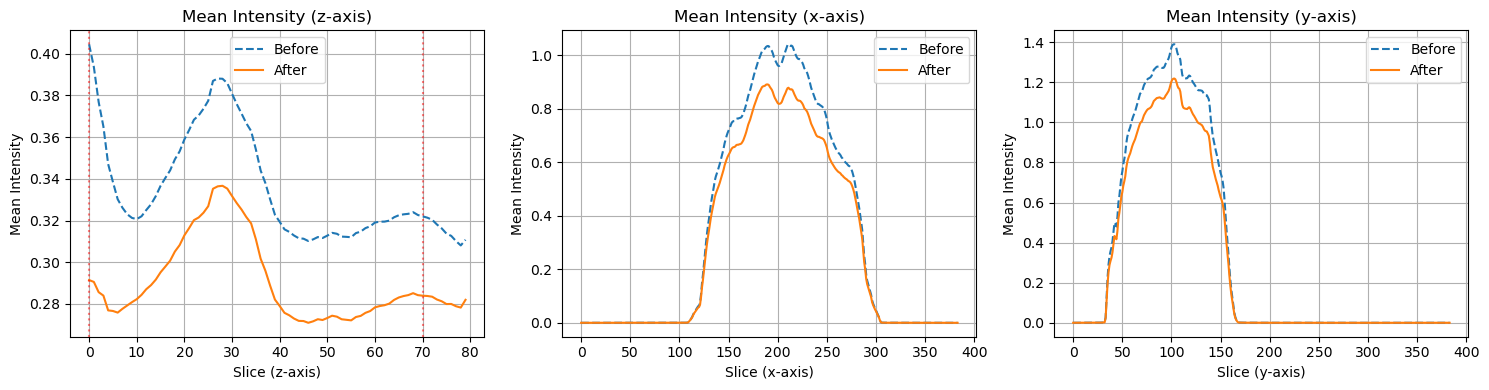

CV before: 0.0771, CV after: 0.0663


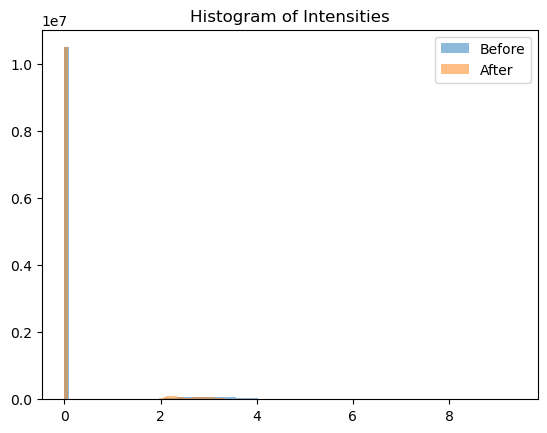

0.025146924

In [9]:
t2_paths = PathFinder("RARE_2D_Ax_preproc.nii")
RARE_file2 = ants.image_read(t2_paths[10])


bias_field = ants.n4_bias_field_correction(RARE_file2,
                                                shrink_factor=1,  # Adjust shrink factor for speed vs accuracy
                                                mask=None,  # Use the mask if available, or set to  
                                                convergence= {'iters': [50, 50, 50, 30], 'tol': 1e-6},                                              
                                                spline_param= 10,  # Adjust spline parameter for bias field smoothness
                                                return_bias_field=True,  # Set to True if you want to return the bias fieldias field
                                                verbose=False)  # Set to True for detailed output
RARE_corrected2 = RARE_file2 / bias_field


#file_path_parent = Path(t2_paths[4]).parent
#outpath = os.path.join(file_path_parent, "RARE_2D_Ax_preproc_BFC.nii.gz")
#ants.image_write(RARE_corrected2, outpath) 



# Evaluate bias field correction
evaluate_bias_field_correction(original_image = RARE_file2, corrected_image = RARE_corrected2, bias_field = bias_field, xi = 110, yi= 200 , zi =40)

['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\89-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\92-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\95-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\98-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\101-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\104-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\107-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\110-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\113-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\116-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\119-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\122-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\125-nii\\RARE_2D_Ax_prepro

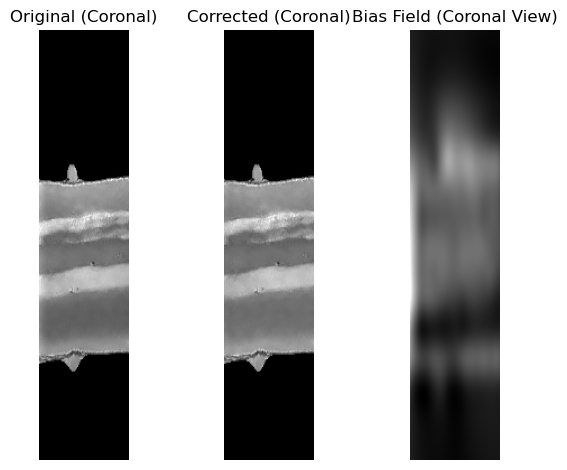

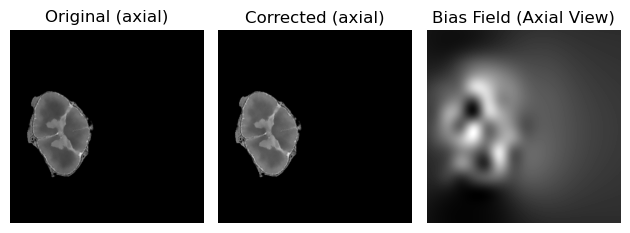

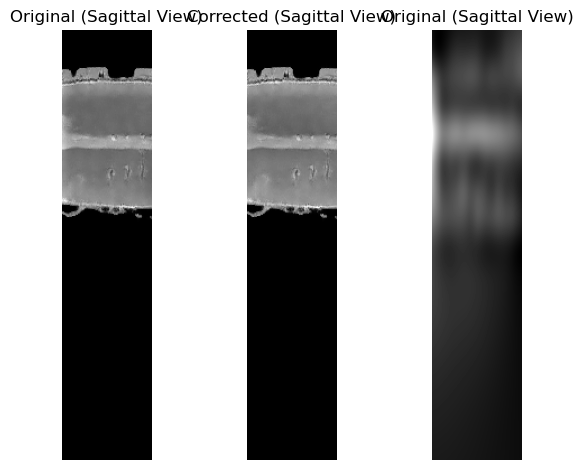

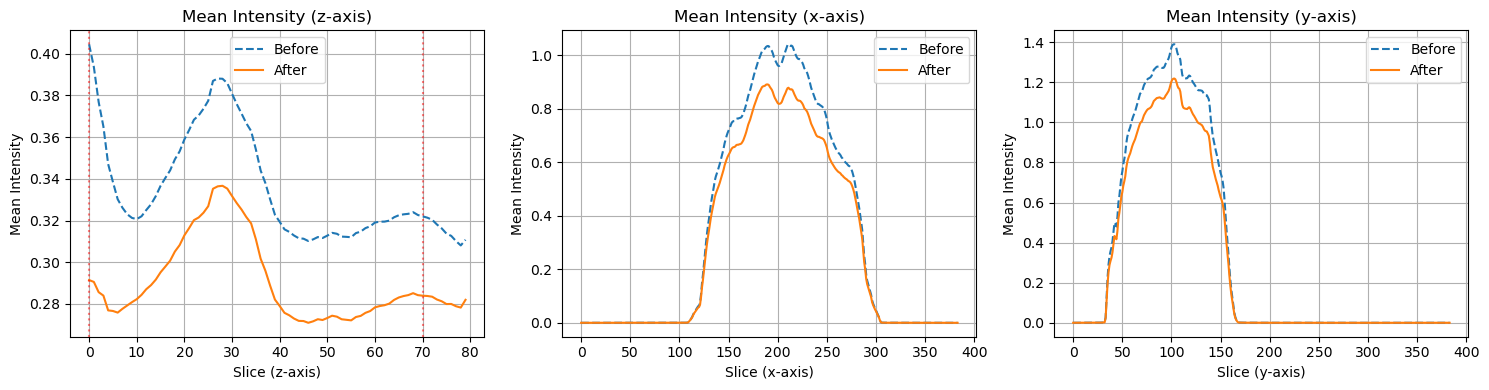

CV before: 0.0771, CV after: 0.0663


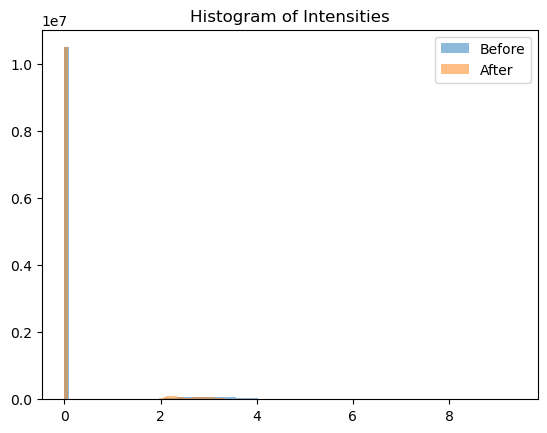

0.025146924

In [10]:
t2_paths = PathFinder("RARE_2D_Ax_preproc.nii")
RARE_file2 = ants.image_read(t2_paths[10])


bias_field2 = ants.n4_bias_field_correction(RARE_file2,
                                                shrink_factor=1,  # Adjust shrink factor for speed vs accuracy
                                                mask=None,  # Use the mask if available, or set to
                                                convergence= {'iters': [50, 50, 50,30], 'tol': 1e-6},                                                
                                                spline_param= 20,  # Adjust spline parameter for bias field smoothness
                                                return_bias_field=True,  # Set to True if you want to return the bias fieldias field
                                                verbose=False)  # Set to True for detailed output
RARE_corrected2 = RARE_file2 / bias_field


#file_path_parent = Path(t2_paths[4]).parent
#outpath = os.path.join(file_path_parent, "RARE_2D_Ax_preproc_BFC.nii.gz")
#ants.image_write(RARE_corrected2, outpath) 



# Evaluate bias field correction
evaluate_bias_field_correction(original_image = RARE_file2, corrected_image = RARE_corrected2, bias_field = bias_field, xi = 110, yi= 200 , zi =40)

['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\89-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\92-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\95-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\98-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\101-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\104-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\107-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\110-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\113-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\116-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\119-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\122-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\125-nii\\RARE_2D_Ax_prepro

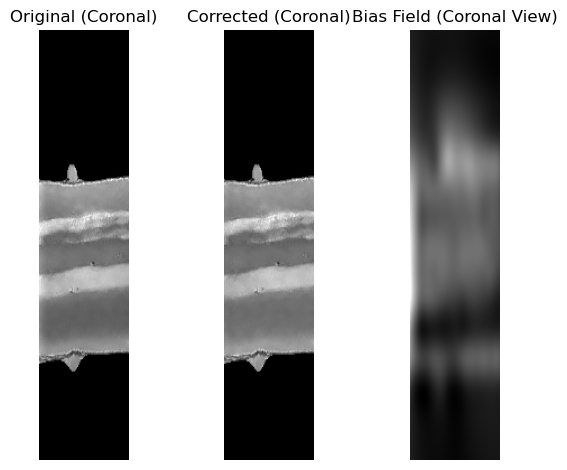

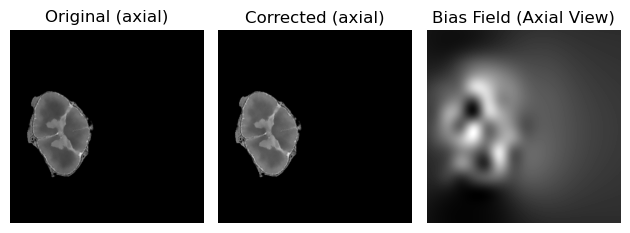

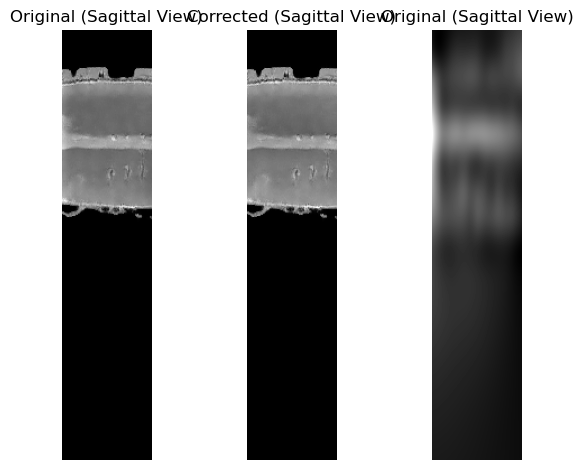

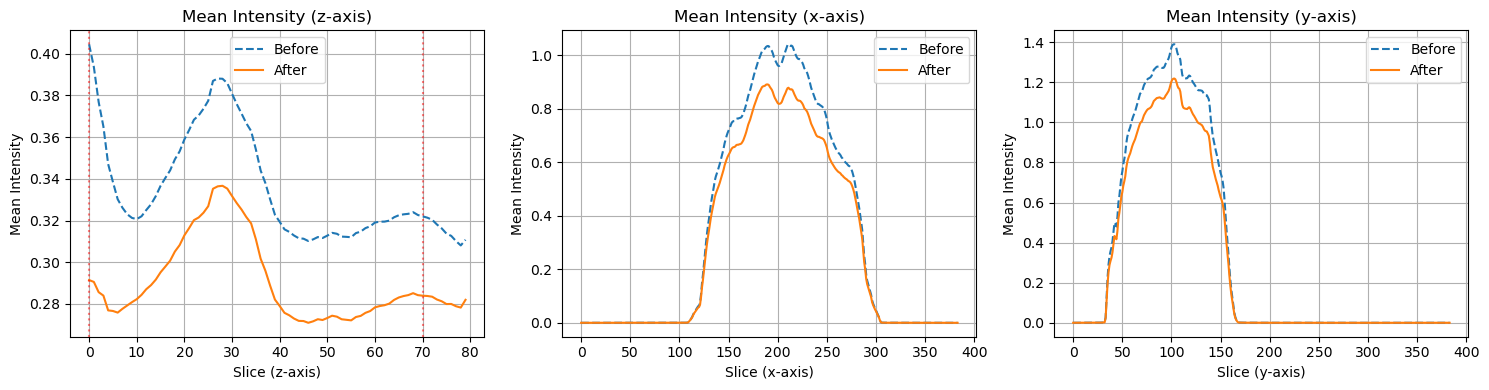

CV before: 0.0771, CV after: 0.0663


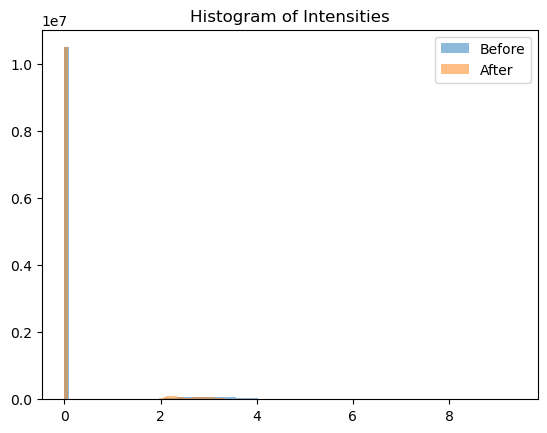

0.025146924

In [11]:
t2_paths = PathFinder("RARE_2D_Ax_preproc.nii")
RARE_file2 = ants.image_read(t2_paths[10])


bias_field2 = ants.n4_bias_field_correction(RARE_file2,
                                                shrink_factor=1,  # Adjust shrink factor for speed vs accuracy
                                                mask=None,  # Use the mask if available, or set to
                                                convergence= {'iters': [50, 50, 50,30], 'tol': 1e-6},                                                
                                                spline_param= [2,2,2],  # Adjust spline parameter for bias field smoothness
                                                return_bias_field=True,  # Set to True if you want to return the bias fieldias field
                                                verbose=False)  # Set to True for detailed output
RARE_corrected2 = RARE_file2 / bias_field


#file_path_parent = Path(t2_paths[4]).parent
#outpath = os.path.join(file_path_parent, "RARE_2D_Ax_preproc_BFC.nii.gz")
#ants.image_write(RARE_corrected2, outpath) 



# Evaluate bias field correction
evaluate_bias_field_correction(original_image = RARE_file2, corrected_image = RARE_corrected2, bias_field = bias_field, xi = 110, yi= 200 , zi =40)

In [ ]:
t2_paths = PathFinder("RARE_2D_Ax_preproc.nii")
RARE_file2 = ants.image_read(t2_paths[10])


bias_field2 = ants.n4_bias_field_correction(RARE_file2,
                                                shrink_factor=1,  # Adjust shrink factor for speed vs accuracy
                                                mask=None,  # Use the mask if available, or set to
                                                convergence= {'iters': [50, 50, 50,30], 'tol': 1e-6},                                                
                                                spline_param= 80,  # Adjust spline parameter for bias field smoothness
                                                return_bias_field=True,  # Set to True if you want to return the bias fieldias field
                                                verbose=False)  # Set to True for detailed output
RARE_corrected2 = RARE_file2 / bias_field


#file_path_parent = Path(t2_paths[4]).parent
#outpath = os.path.join(file_path_parent, "RARE_2D_Ax_preproc_BFC.nii.gz")
#ants.image_write(RARE_corrected2, outpath) 



# Evaluate bias field correction
evaluate_bias_field_correction(original_image = RARE_file2, corrected_image = RARE_corrected2, bias_field = bias_field, xi = 110, yi= 200 , zi =40)

In [37]:
RARE_file2.spacing

(0.05000000074505806, 0.05000000074505806, 0.20000000298023224)

In [43]:
def stitch_sections_with_weighted_blend(section_A_path, section_B_path, output_path,
                                         overlap_slices=10, margin_slices=2, trials=50, blend = 'linear'):
    """
    Stitches two spinal cord sections using multi-trial rigid registration on overlapping regions
    and performs a weighted blend of the overlapping region.

    Parameters:
        section_A_path (str): Path to the first section.
        section_B_path (str): Path to the second section.
        output_path (str): Path to save the stitched image.
        overlap_slices (int): Number of slices for overlap (default: 10).
        margin_slices (int): Displacement margin in slices.
        trials (int): Registration trials for robustness.
    """

    #################### Load images ###########################
    section_A = ants.image_read(section_A_path)
    section_B = ants.image_read(section_B_path)

    #section_B.set_spacing(section_A.spacing)
    #section_B.set_origin(section_A.origin)
    #section_B.set_direction(section_A.direction)

    best_mi = float(0)
    best_transform = None
    best_displacement = 0

    #################  Iterate over displacement windows within the margin ##########################
    for displacement in range(0, margin_slices + 1):
        print(f"Testing displacement: {displacement} slices")

        # Overlapping portions
        overlap_A_data = section_A.numpy()[:, :, :overlap_slices]

        start = -(overlap_slices + displacement)
        end = -displacement if displacement != 0 else None  # avoid -0 → 0 confusion
        overlap_B_data = section_B.numpy()[:, :, start:end]
        #overlap_B_data = section_B.numpy()[:, :, -(overlap_slices+displacement):-(displacement+1)]

        print(f"Overlap A shape: {overlap_A_data.shape}, Overlap B shape: {overlap_B_data.shape}")

        overlap_A = ants.from_numpy(overlap_A_data, origin=section_A.origin,
                                    spacing=section_A.spacing, direction=section_A.direction)
        overlap_B = ants.from_numpy(overlap_B_data, origin=section_B.origin,
                                    spacing=section_B.spacing, direction=section_B.direction)

        trial_mi_scores = []

        for i in range(trials):
            transform = ants.registration(fixed=overlap_A, moving=overlap_B, type_of_transform="Rigid")
            registered_B = ants.apply_transforms(fixed=overlap_A, moving=overlap_B,
                                                 transformlist=transform['fwdtransforms'])
            mi = ants.image_similarity(fixed_image=overlap_A, moving_image=registered_B,
                                       metric_type='MattesMutualInformation')
            trial_mi_scores.append(mi)

        mean_mi = np.mean(trial_mi_scores)
        print(f"Displacement {displacement}: Mean MI over {trials} trials = {mean_mi}")
        
        # Update best metrics
        if displacement == 0:
            best_mi = mean_mi
            best_transform = transform['fwdtransforms']
            best_displacement = displacement

        if mean_mi < best_mi:
            best_mi = mean_mi
            best_transform = transform['fwdtransforms']
            best_displacement = displacement

    print(f"Best displacement: {best_displacement} with mean MI = {best_mi}")


        
    ################ Register full section B to A ##########################
    registered_B = ants.apply_transforms(fixed=section_A, moving=section_B, transformlist=best_transform)
    print(f"Final registered_B.shape: {registered_B.shape}, section_A.shape: {section_A.shape}")



    mean_profile = np.mean(registered_B[:, 180, :], axis=0)
    zero_mean_indices = np.where(mean_profile != 0)[0]
    zB = max(zero_mean_indices) +1 

    registered_zB = registered_B[:, :, :zB]  # Keep only last Zb slices
    print(f"registered_zB.shape: {registered_zB.shape}, section_A.shape: {section_A.shape}")


    ################### Stitch the sections with weighted blend ###################
    # Prepare arrays
    A_array = section_A.numpy()
    B_array = registered_zB

    
    if blend == 'linear':
        # Weighted blend in the overlap
        weight_A = np.linspace(0, 1, overlap_slices).reshape(1, 1, -1)
        weight_B = 1 - weight_A

    if blend == 'cosine':
        # Cosine blend from 0 to 1 over overlap_slices
        z = np.linspace(0, np.pi, overlap_slices).reshape(1, 1, -1)
        weight_A = (1 - np.cos(z)) / 2 # 0 at the start, 1 at the end following a cosine curve 
        weight_B = 1 - weight_A  # Inverse of weight_A so it sums to 1. 


    A_overlap = A_array[:, :, :overlap_slices] * weight_A
    B_overlap = B_array[:, :, -overlap_slices:] * weight_B
    blended_overlap = A_overlap + B_overlap

    # Concatenate: A (non-overlap) + blended + B (non-overlap)
    stitched_data = np.concatenate([
        B_array[:, :, :-overlap_slices] , blended_overlap , A_array[:, :, overlap_slices:]
    ], axis=2)

    stitched_image = ants.from_numpy(stitched_data, origin=section_A.origin,
                                        spacing=section_A.spacing, direction=section_A.direction)




    ants.image_write(stitched_image, output_path)
    print(f"Stitched image saved to {output_path}")

    # Create a named array (dictionary) with relevant values
    stitch_info = {
        'section_A_path': section_A_path,
        'section_B_path': section_B_path,
        'zB': zB,
        'best_mi': best_mi,
        'best_displacement': best_displacement,
        'blend_type': blend,
        'overlap_slices': overlap_slices
    }
    return stitched_image, stitch_info


In [3]:
####################### Bias Field Correction on All Files ####################### 
t2_paths = PathFinder("RARE_2D_Ax_preproc.nii")
for path in t2_paths:
    file_path_parent = Path(path).parent
    outpath = os.path.join(file_path_parent, "RARE_2D_Ax_preproc_BFC_1_1_1.nii.gz")

    print(f"Starting processing for {path}")

    #check if the file exists
    #if os.path.exists(outpath):
    #    print(f"File already exists: {outpath}")
    #    continue  # Skip processing if the file already exist

    # Apply N4 bias field correction
    RARE_file = ants.image_read(path)
    print("Starting N4 bias field correction...")

    bias_field = ants.n4_bias_field_correction(RARE_file,
                                                    shrink_factor=1,  # Adjust shrink factor for speed vs accuracy
                                                    mask=None,  # Use the mask if available, or set to None
                                                    convergence= {'iters': [50, 50, 50,30], 'tol': 1e-6},
                                                    spline_param = 1,  # Adjust spline parameter for bias field smoothness
                                                    return_bias_field=True,  # Set to True if you want to return the bias field
                                                    verbose=False)  # Set to True for detailed output
    
    RARE_corrected = RARE_file / bias_field


    # Save the corrected image
    ants.image_write(RARE_corrected, outpath)
    np.save(os.path.join(file_path_parent, "bias_field_1_1_1.npy"), bias_field.numpy())

['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\89-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\92-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\95-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\98-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\101-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\104-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\107-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\110-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\113-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\116-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\119-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\122-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\125-nii\\RARE_2D_Ax_prepro

In [ ]:
####################### Bias Field Correction on All Files ####################### 
t2_paths = PathFinder("RARE_2D_Ax_preproc.nii")
for path in t2_paths:
    file_path_parent = Path(path).parent
    outpath = os.path.join(file_path_parent, "RARE_2D_Ax_preproc_BFC.nii.gz")

    print(f"Starting processing for {path}")

    #check if the file exists
    #if os.path.exists(outpath):
    #    print(f"File already exists: {outpath}")
    #    continue  # Skip processing if the file already exist

    # Apply N4 bias field correction
    RARE_file = ants.image_read(path)
    print("Starting N4 bias field correction...")

    bias_field = ants.n4_bias_field_correction(RARE_file,
                                                    shrink_factor=1,  # Adjust shrink factor for speed vs accuracy
                                                    mask=None,  # Use the mask if available, or set to None
                                                    convergence= {'iters': [50, 50, 50,30], 'tol': 1e-6},
                                                    spline_param= [2,2,2],  # Adjust spline parameter for bias field smoothness
                                                    return_bias_field=True,  # Set to True if you want to return the bias field
                                                    verbose=False)  # Set to True for detailed output
    
    RARE_corrected = RARE_file / bias_field


    # Save the corrected image
    ants.image_write(RARE_corrected, outpath)
    np.save(os.path.join(file_path_parent, "bias_field_2_2_2.npy"), bias_field.numpy())

['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\89-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\92-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\95-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\98-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\101-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\104-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\107-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\110-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\113-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\116-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\119-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\122-nii\\RARE_2D_Ax_preproc.nii.gz', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\125-nii\\RARE_2D_Ax_prepro

**Preproc Combined Data**

In [ ]:
#Struc files Combined
RARE_combined, RARE_affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/RARE_combined_trans.nii.gz")
RARE_All = RARE_combined


##### Denoise ###
# Estimate noise standard deviation
sigma = estimate_sigma(RARE_All)

# Apply Non-Local Means (NLM) denoising
denoised_data = nlmeans(RARE_All, sigma = sigma, patch_radius=2, block_radius=5)


### Gibbs Correction ####
data_corrected = gibbs_removal(denoised_data, slice_axis=2, num_processes=-1)


#Mask
RARE_combined_masked, mask = median_otsu(data_corrected, median_radius=4, numpass=4,
                                     autocrop=False, dilate=None)

RARE_masked_data = RARE_combined_masked[0]
RARE_mask = RARE_combined_masked[1]

#Saving Files
path = "C:/DTI_SC/humanSC_400h/Combined_Data/RARE_combined_trans_denoised_gibbs_masked.nii.gz"

RARE_masked_data_nifti = nib.Nifti1Image(RARE_combined_masked,   affine = RARE_affine_all)

save_nifti(path, RARE_masked_data_nifti.get_fdata(),
    RARE_masked_data_nifti.affine)

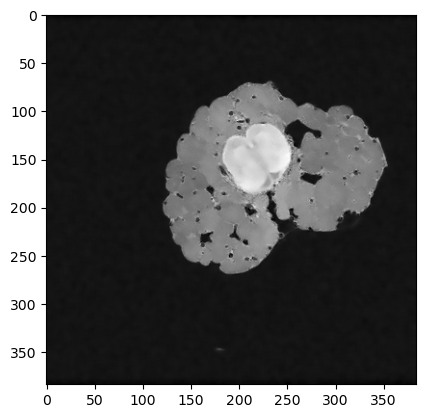

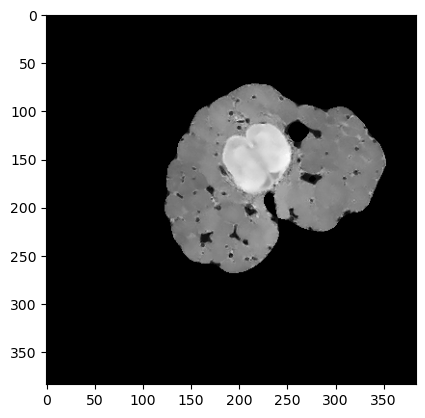

In [40]:
z= -150
plt.imshow(data_corrected[:,:,z], cmap='gray')
plt.show()

plt.imshow(RARE_combined_masked[:,:,z], cmap='gray')

# Preprocessing DTI
Steps:
- 0. (FSL eddy need to figure out how to do that best (not sure I can with only 1 phase encoding direction and 1 shell)) 
- 1. Denoise
- 2. Gibbs Correction
- 3. (Try) Motion Correction (didnt improve)

In [ ]:
# Start with preprocessing:
#Denoise 
DTI_paths = PathFinder("Dti_SE.nii")
noise_dict = mppca_denoise(file_paths = DTI_paths, output_name = "denoised_affine_ok")

#Gibbs Correction.
DTI_paths = PathFinder("denoised_affine_ok")
gibbs_correct(file_paths= DTI_paths, output_name= "gibbs_denoised_affine_ok")


In [ ]:
### Motion Correction (Test)
fbval = 'C:/DTI_SC/humanSC_400h/bval.txt'
fbvec = 'C:/DTI_SC/humanSC_400h/MPG80_bvec.txt'
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

DTI_denoised_gibbs_paths = PathFinder("gibbs_denoised_affine_ok")

#Load in Image
data_gibbs_denoised, affine = load_nifti(DTI_denoised_gibbs_paths[3])

#Motion Correct
data_moiton_gibbs_denoised, reg_affines = motion_correction(data_gibbs_denoised, gtab, affine)

save_nifti("motion_gibbs_denoised_97", data_moiton_gibbs_denoised.get_fdata(),
                data_moiton_gibbs_denoised.affine)


In [ ]:
####################### Bias Field Correction on All Files ####################### 
DTI_denoised_gibbs_paths = PathFinder("gibbs_denoised_affine_ok")


for path in DTI_denoised_gibbs_paths:
    file_path_parent = Path(path).parent
    outpath = os.path.join(file_path_parent, "DTI_SE_BFC_gibbs_denoised_affine_ok.nii.gz")

    print(f"Starting processing for {path}")
    # Apply N4 bias field correction
    DTI_file = ants.image_read(path)

    b0 = DTI_file[:,:,:,0:3]
    b0_mean = np.mean(b0, axis=3)

    direction_clean = np.array(DTI_file.direction[:3, :3], dtype=np.float64, order='C')
    #print("Shape:", direction_clean.shape)
    #print("Contiguous:", direction_clean.flags['C_CONTIGUOUS'])

    b0_mean_ants = ants.from_numpy(
        b0_mean,
        origin= DTI_file.origin[:3],
        spacing= DTI_file.spacing[:3],
        direction= direction_clean
    )

    print("Starting N4 bias field correction...")

    bias_field = ants.n4_bias_field_correction(b0_mean_ants,
                                                    shrink_factor=1,  # Adjust shrink factor for speed vs accuracy
                                                    mask=None,  # Use the mask if available, or set to None
                                                    convergence= {'iters': [50, 50, 50,30], 'tol': 1e-6},
                                                    spline_param= [1,1,1],  # Adjust spline parameter for bias field smoothness
                                                    return_bias_field=True,  # Set to True if you want to return the bias field
                                                    verbose=False)  # Set to True for detailed output
    # Create a new array to store the corrected DTI
    DTI_corrected = np.empty_like(DTI_file.numpy())

    # Apply the bias field to each volume (last dimension)
    for i in range(DTI_file.shape[3]):
        DTI_corrected[:, :, :, i] = DTI_file.numpy()[:, :, :, i] / bias_field.numpy()

    print(f"Corrected DTI shape: {DTI_corrected.shape}, Original DTI shape: {DTI_file.shape}")

    # Save the corrected image
    DTI_corrected_ants = ants.from_numpy(DTI_corrected, origin=DTI_file.origin,
                                          spacing=DTI_file.spacing, direction=DTI_file.direction)
    ants.image_write(DTI_corrected_ants, outpath)
    np.save(os.path.join(file_path_parent, "bias_field_2_2_2.npy"), bias_field.numpy())


### Fix Affine

In [ ]:
fbval = 'C:/DTI_SC/humanSC_400h/bval.txt'
fbvec = 'C:/DTI_SC/humanSC_400h/MPG80_bvec.txt'
gtab = gradient_table(fbval, fbvec)

DTI_denoised_gibbs_paths = PathFinder("gibbs_denoised_affine_ok")
DTI_paths = PathFinder("Dti")


#### Check Affine is the right one ######
for i in range(DTI_denoised_gibbs_paths.__len__()):
    #Load Data
    data, affine = load_nifti(DTI_paths[i])
    data2, affine2 = load_nifti(DTI_denoised_gibbs_paths[i])
    
    affine_good = np.all(affine == affine2)
    print(f"{i} = ", affine_good)

    if affine_good == False:
        path = DTI_denoised_gibbs_paths[i]
        path_fixed = path.replace("/", "\\")
        path_fixed = path_fixed.replace("ok","ok_new")
    #Saving Files
        affine_fixed = nib.Nifti1Image(data2,   affine = affine)
        save_nifti(path_fixed, affine_fixed.get_fdata(),
            affine_fixed.affine)


###### Check if the affine is the same for all scans 88:173-nii (for the dwMRI)######
affine_list = np.empty(shape = (4,4,29))

for i in range(DTI_denoised_gibbs_paths.__len__()):
    data2, affine2 = load_nifti(DTI_denoised_gibbs_paths[i])
    affine_list[:,:,i] = affine2


# Check if all numbers along the z-axis (axis=2) are equal for each (x, y) position
equal_check = np.all(affine_list == affine_list[:, :, 0:1], axis=2)
equal_check

#### Generate **Mask** for Gibbs -> Denoised data

In [ ]:
DTI_denoised_gibbs_paths = PathFinder("gibbs_denoised_affine_ok")

for file_path in DTI_denoised_gibbs_paths:
    print("starting with file:",file_path)

    #find the correct paths to file and outcome directory.
    file_path = Path(file_path)
    outcomepath = file_path.parent

    data, affine = load_nifti(file_path)

    #Find mask
    maskdata, mask = median_otsu(data, vol_idx= np.arange(0,80), median_radius=4, numpass=4, autocrop=False, dilate= None)

    #Save as numpy array
    print("Saving Files")
    #np.save(os.path.join(outcomepath,"maskdata"), maskdata)
    np.save(os.path.join(outcomepath,"mask"),mask)


In [ ]:
DTI_denoised_gibbs_paths = PathFinder("gibbs_denoised_affine_ok")

#Trying Out Different Parameters for Mask generation!

data, affine = load_nifti(DTI_denoised_gibbs_paths[8])
data_trans = np.transpose(data, axes= (1,0,2,3)) #Flip the data

#Find mask
maskdata1, mask3 = median_otsu(data_trans, vol_idx= np.arange(0,80), median_radius=1, numpass=3, autocrop=False, dilate= 2)
maskdata2, mask4 = median_otsu(data_trans, vol_idx= np.arange(0,80), median_radius=2, numpass=3, autocrop= False, dilate = 2)
maskdata3, mask3 = median_otsu(data_trans, vol_idx= np.arange(0,80), median_radius=3, numpass=3, autocrop=False, dilate= 2)
maskdata4, mask4 = median_otsu(data_trans, vol_idx= np.arange(0,80), median_radius=4, numpass=3, autocrop= False, dilate = 2)

plt.imshow(data_trans[:,:,30,0])
plt.title("Non Masked Data")
plt.show()

plt.imshow(maskdata1[:,:,30,0])
plt.title("Median Radius = 1, Numpasses = 3")
plt.show()

plt.imshow(maskdata2[:,:,30,0])
plt.title("Median Radius = 2, Numpasses = 3")
plt.show()


plt.imshow(maskdata3[:,:,30,0])
plt.title("Median Radius = 3, Numpasses = 3")
plt.show()

plt.imshow(maskdata4[:,:,30,0])
plt.title("Median Radius = 4, Numpasses = 3")
plt.show()

#Find mask
maskdata1, mask3 = median_otsu(data_trans, vol_idx= np.arange(0,80), median_radius=1, numpass=4, autocrop=False, dilate= 2)
maskdata2, mask4 = median_otsu(data_trans, vol_idx= np.arange(0,80), median_radius=2, numpass=4, autocrop= False, dilate = 2)
maskdata3, mask3 = median_otsu(data_trans, vol_idx= np.arange(0,80), median_radius=3, numpass=4, autocrop=False, dilate= 2)
maskdata4, mask4 = median_otsu(data_trans, vol_idx= np.arange(0,80), median_radius=4, numpass=4, autocrop= False, dilate = 2)


plt.imshow(data_trans[:,:,30,0])
plt.title("Non Masked Data")
plt.show()

plt.imshow(maskdata1[:,:,30,0])
plt.title("Median Radius = 1, Numpasses = 4")
plt.show()

plt.imshow(maskdata2[:,:,30,0])
plt.title("Median Radius = 2, Numpasses = 4")
plt.show()


plt.imshow(maskdata3[:,:,30,0])
plt.title("Median Radius = 3, Numpasses = 4")
plt.show()

plt.imshow(maskdata4[:,:,30,0])
plt.title("Median Radius = 4, Numpasses = 4")
plt.show()

# 2nd way 
1. Mask
2. Movement 
3. mpPCA (denoise)
4. gibbs correction

### 1. Generate mask 

In [1]:

for file_path in DTI_paths:
    print("starting with file:",file_path)

    #find the correct paths to file and outcome directory.
    file_path = Path(file_path)
    outcomepath = file_path.parent

    #load data
    data, affine = load_nifti(file_path)
    data_trans = np.transpose(data, axes= (1,0,2,3)) #Flip the data

    #Find mask
    b0_mask, mask = median_otsu(data_trans, median_radius=2, numpass=1, vol_idx= np.arange(0,80))

    print("Saving Files")
    
    #Save as numpy array
    np.save(os.path.join(outcomepath,"b0_mask"), b0_mask)
    np.save(os.path.join(outcomepath,"mask"),mask)

    #save as nifti file
    b0_mask_nifti = nib.Nifti1Image(b0_mask,   affine = np.eye(4))
    nib.save(b0_mask_nifti, os.path.join(outcomepath,"masked_data"))

    mask_int = mask.astype(int)
    mask_nifti = nib.Nifti1Image(mask_int,   affine = np.eye(4))
    nib.save(mask_nifti, os.path.join(outcomepath,"binary_mask"))
    print("Done!")



NameError: name 'DTI_paths' is not defined

### 2. Motion correction

In [71]:
masked_data_paths = PathFinder(searchword_starts_with = "masked_data")

for file_path in masked_data_paths:
    #find the correct paths to file and outcome directory.
    file_path = Path(file_path)
    outcomepath = file_path.parent


    if os.path.isfile(os.path.join(outcomepath,"masked_motion_corrected_data.nii")):
        print(outcomepath, "Already exist/Completed")
    else:
        print(outcomepath, "Didn't exist- Starting")
        #load data
        data, affine = load_nifti(file_path)


        #Motion Correction on non mask data
        data_corrected, reg_affines = motion_correction(data, gtab, affine)

        #Saving Files
        print("Saving Files")
        save_nifti(os.path.join(outcomepath,"masked_motion_corrected_data"), data_corrected.get_fdata(),
                data_corrected.affine)
        print("Done!")


['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\88-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\91-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\94-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\97-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\100-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\103-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\106-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\109-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\112-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\115-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\118-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\121-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\124-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\127-nii\\masked_data.nii', 'C:/DTI_SC/humanSC_400h\\190812-HumanSC\\130-nii\\m

In [127]:
data_corrected, affine = load_nifti("C:/DTI_SC/humanSC_400h/190805-HumanSC/88-nii/motion_correction.nii.gz")

data_corrected_masked, affine = load_nifti("C:/DTI_SC/humanSC_400h/190805-HumanSC/88-nii/motion_correction_masked.nii.gz")

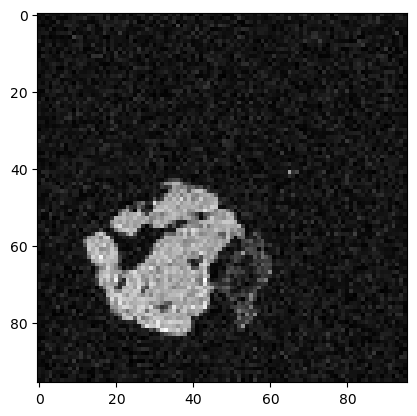

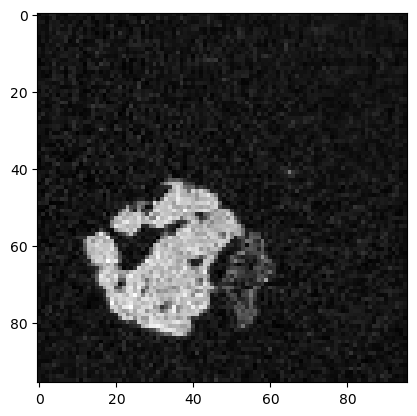

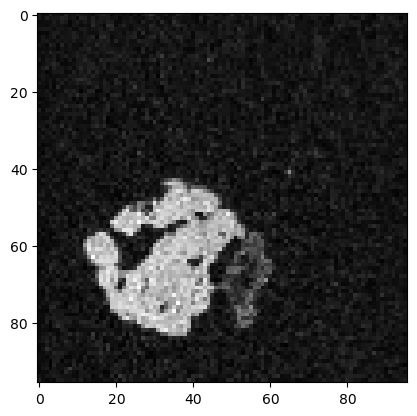

In [123]:
# Initial setup for the plot
slice = 70
plt.imshow(data_corrected[:,:,slice,0],"grey")
plt.show()
plt.imshow(data_corrected[:,:,slice,1],"grey")
plt.show()
plt.imshow(data_corrected[:,:,slice,2],"grey")
plt.show()

## Denoise
Internally, the mppca algorithm denoises the diffusion-weighted data using a 3D sliding window which is defined by the variable patch_radius. In total, this window should comprise a larger number of voxels than the number of diffusion-weighted volumes. Since our data has a total of 67 volumes, the patch_radius is set to 2 which corresponds to a 5x5x5 sliding window comprising a total of 125 voxels.


In [ ]:
# load main pca function using Marcenko-Pastur distribution
from dipy.denoise.localpca import mppca
from scipy.io import savemat

#Find all paths 
masked_motion_data_paths = PathFinder(searchword_starts_with = "masked_motion_corrected_data")

sigma_dict = mppca_denoise(file_path = masked_motion_data_paths, output_name = "masked_motion_corrected_denoised_data")



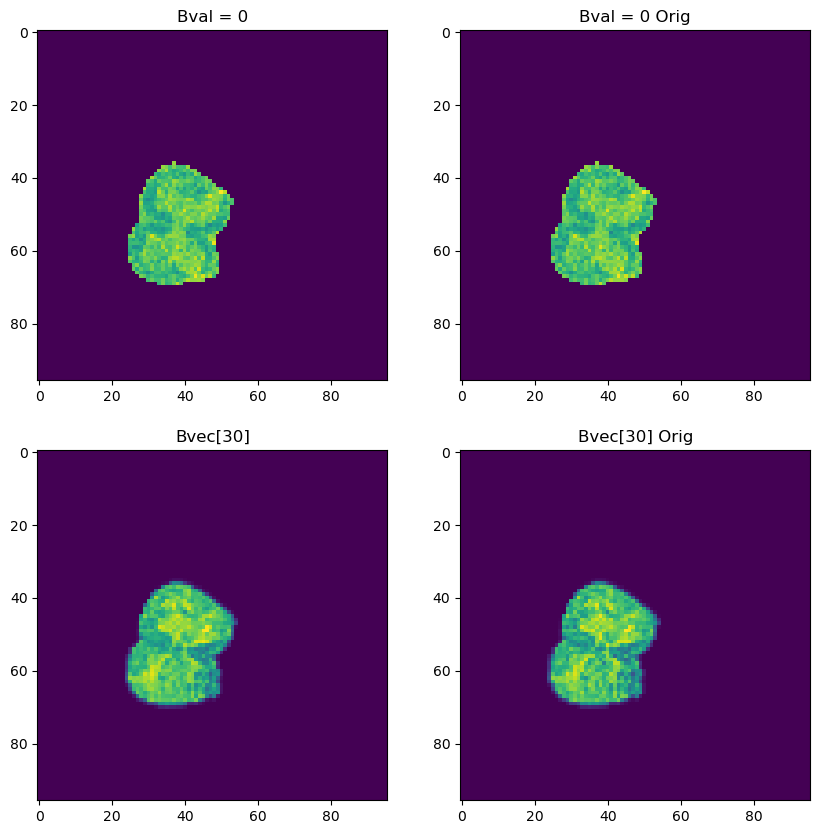

In [ ]:
denoised_arr, affine = load_nifti("C:/DTI_SC\humanSC_400h/190805-HumanSC/94-nii/masked_motion_corrected_denoised_data.nii")


slice = 10
fig, axes = plt.subplots(2,2, figsize = (10,10))

#Denoised Images 
axes[0,0].imshow(denoised_arr[:,:,slice,0])
axes[0,0].set_title("Bval = 0")

axes[1,0].imshow(denoised_arr[:,:,slice,30])
axes[1,0].set_title("Bvec[30]")

#Original Images 
axes[0,1].imshow(denoised_arr[:,:,slice,0])
axes[0,1].set_title("Bval = 0 Orig")

axes[1,1].imshow(denoised_arr[:,:,slice,30])
axes[1,1].set_title("Bvec[30] Orig")

plt.show()

Text(0.5, 1.0, 'Residuals')

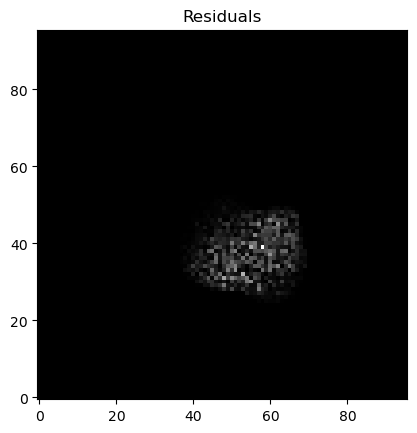

In [ ]:
data_c_mc, affine = load_nifti("C:/DTI_SC\humanSC_400h/190805-HumanSC/94-nii/masked_motion_corrected_data.nii")

rms_diff = np.sqrt((data_c_mc[:,:,10,30] - denoised_arr[:,:,10,30]) ** 2)

plt.imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower')
plt.title('Residuals')


## Gibbs Correction

In [105]:
from dipy.denoise.gibbs import gibbs_removal

#Find all paths 
masked_motion_denoise_data_paths = PathFinder(searchword_starts_with = "masked_motion_corrected_denoised_data")


for file_path in masked_motion_denoise_data_paths:
    #find the correct paths to file and outcome directory.
    file_path = Path(file_path)
    # Get the parent dictonairy where our file is located
    outcomepath = file_path.parent
    # Get the last part of the path
    last_part = outcomepath.name

    if os.path.isfile(os.path.join(outcomepath,"masked_motion_corrected_denoised__gibbsC_data.nii")):
        print(outcomepath, "Gibbs Corrected Already exist/Completed")
    else:
        print(outcomepath, "Gibbs Correceted Didn't exist- Starting")
        #load data
        data, affine = load_nifti(file_path)

        #Motion Correction on non mask data
        data_corrected = gibbs_removal(data, slice_axis=2, num_processes=-1)

        #Saving Files
        print("Saving Files")
        gibbs_correc = nib.Nifti1Image(data_corrected,   affine = np.eye(4))
        save_nifti(os.path.join(outcomepath,"masked_motion_corrected_denoised__gibbsC_data"), gibbs_correc.get_fdata(),
                gibbs_correc.affine)
        print("Done!")


['C:/DTI_SC/humanSC_400h\\190805-HumanSC\\88-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\91-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\94-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190805-HumanSC\\97-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\100-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\103-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\106-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190807-HumanSC\\109-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\112-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\115-nii\\masked_motion_corrected_denoised_data.nii', 'C:/DTI_SC/humanSC_400h\\190809-HumanSC\\118-nii\\masked_motion

Text(0.5, 1.0, 'Raw Data')

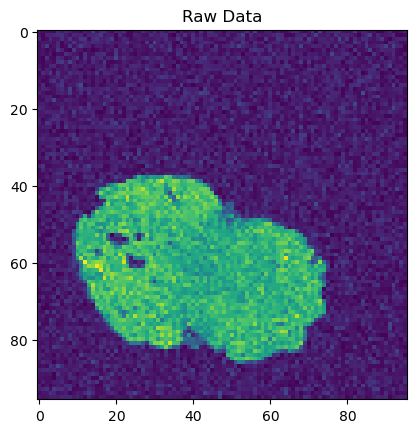

In [91]:
data_m, affine_m = load_nifti(DTI_paths[0])

plt.imshow(data_m[:,:,40,0])
plt.title("Raw Data")

Text(0.5, 1.0, 'only masked')

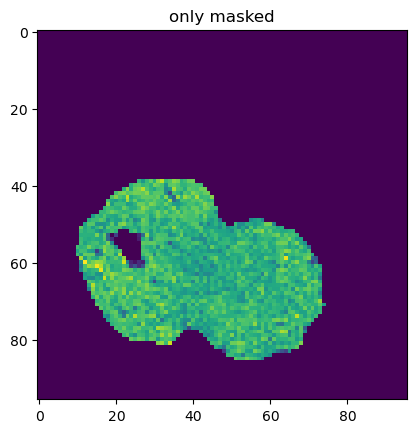

In [92]:
data_m, affine_m = load_nifti(masked_data_paths[0])

plt.imshow(data_m[:,:,40,0])
plt.title("only masked")

Text(0.5, 1.0, 'only masked,motion and denoised')

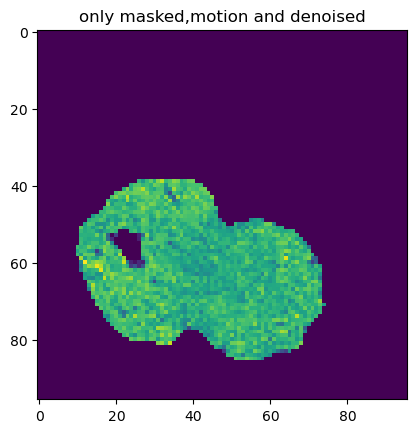

In [94]:
plt.imshow(data[:,:,40,0])
plt.title("only masked,motion and denoised")

Text(0.5, 1.0, 'only masked,motion, denoised and gibbs correction')

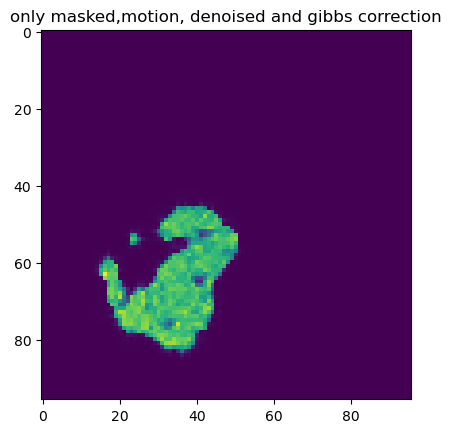

In [98]:
plt.imshow(data_corrected[:,:,70,0])
plt.title("only masked,motion, denoised and gibbs correction")

# Mask generation Post

In [11]:
dti, affine = load_nifti("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")

In [2]:
DTI_combined_preproc_trans_masked_rotated, affine = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")



In [ ]:
masked_DTI , mask_DTI = median_otsu(DTI_combined_preproc_trans_masked_rotated, vol_idx= np.arange(3), median_radius=2, numpass=4)

# Convert mask_DTI to uint8 before saving as NIfTI
nib.save(
	nib.Nifti1Image(mask_DTI.astype('uint8'), affine),
	"C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_MASK_combined_preproc_trans_masked_rotated.nii.gz"
)

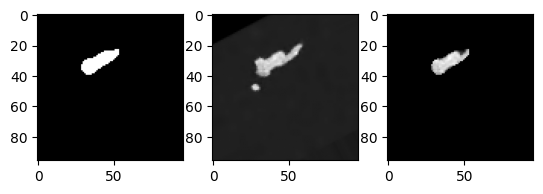

In [21]:
z = -0
plt.subplot(1,3,1)
plt.imshow(mask_DTI[:, :, z], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(DTI_combined_preproc_trans_masked_rotated[:, :, z, 0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(masked_DTI[:, :, z, 0], cmap='gray')